In [1]:
using Flux
using Plots

# Simple Models 

In [2]:
W = rand(2, 5)
b = rand(2)

predict(x) = W*x .+ b

function loss(x, y)
    y_ = predict(x)
    sum((y .- y_).^2)
end

x, y = rand(5), rand(2) # dummy data
@show loss(x, y)

# Compute gradients
gs = gradient(() -> loss(x, y), params(W, b))
dW = gs[W]

# Update with respect to W
W .-= 0.2 .* dW

@show loss(x, y)

loss(x, y) = 5.187134151983805
loss(x, y) = 0.8758189491813237


0.8758189491813237

# First Attempt at Reparametrizer 

In [199]:
module dev
using Flux
function squaresum(x)
    out = x[1]^2
    for i in 2:length(x)
        out += x[i]^2
    end
    out
end

function vecnorm2(x)
    return sqrt(squaresum(x))
end

struct Qmap{T<:Function, TF<:Real}; c::T; h::TF; end
(q::Qmap)(x) = sqrt(vecnorm2(0.5 * (q.c(x+q.h) - q.c(x-q.h)) / q.h)) * q.c(x)


struct SineLayer{T<:Real}; N::Int; c::Vector{T}; end 
SineLayer(c) = SineLayer(length(c), c)
SineLayer(N::Int; scale::Real=0.) = SineLayer(N, scale*rand(N))


function (S::SineLayer)(x, y)
    z = sin(π*x) * S.c[1]
    y1 = π * cos(π*x) * S.c[1]
    for n in 2:S.N
        z += sin(n*π*x) * S.c[n]
        y1 += n * π * cos(n*π*x) * S.c[n]
    end
    return x + z, (one(y1) + y1 ) * y
end

(S::SineLayer)(x) = S(x, convert(typeof(x), 1.))
(S::SineLayer)(x::Tuple) = S(x...)

Flux.@functor SineLayer
end # module

Main.dev

In [232]:
# Define test curves and reparametrization
c(t) = [cos(2π*t), sin(2π*t)]
γ(t) = 0.9t^2 + 0.1t
ψ(t) = 0.5 * log(20t + 1) / log(21) + 0.25 * (1 + tanh(20*(t-0.5))/tanh(21))
c2 = c ∘ γ
c2 = c ∘ ψ

# Get Q-maps
r = dev.Qmap(c, 1e-4)
q = dev.Qmap(c2, 1e-4)


# Define a "batch" of K test points
K = 1024
X = range(0, 1, length=K)
# X = collect(Float32, X)


# Define loss function
function loss(m, q, r, X)
    Q = q.(X)
    O = m.(X)
    R = [sqrt(oi[2]) * r(oi[1]) for oi in O]
    return sum(dev.squaresum.(Q - R))
end


# opt = Momentum(1e-7, 0.001)
opt = Descent(1e-7)
# opt = ADAM(1e-3, (0.9, 0.99))
# opt = ADAGrad(1e-2)

ADAGrad(0.01, IdDict{Any,Any}())

In [235]:
m = Chain(dev.SineLayer(5), dev.SineLayer(5))
ps = params(m)
data = [(m, q, r, X) for _ in 1:300];

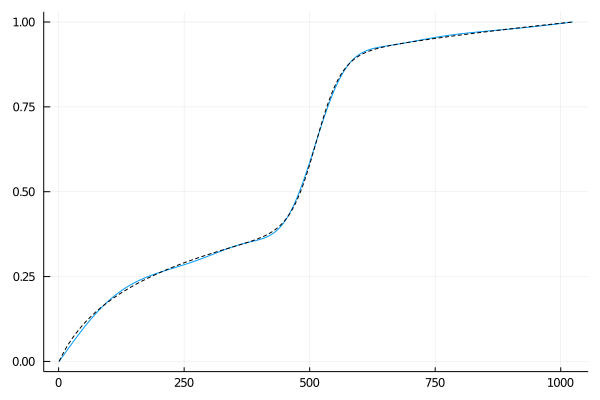

In [236]:
Flux.train!(loss, ps, data, opt)
plot((x->m(x)[1]).(X), legend=false)
plot!(ψ.(X), color=:black, ls=:dash)